### 1- Dataset acquisition 
Dataset link : https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

Contains two classes : Without mask and with mask 

3725 Images of Face with Mask
3828 Images of Face without Mask.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 44
directory="Dataset/Train"
categories=["Mask","Non Mask"]
print("[INFO] loading images...")

data = []
labels = []
for imagePath in categories:
    path=os.path.join(directory,imagePath)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(imagePath)

[INFO] loading images...


In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42)


aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [7]:
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________

C:\Users\srich\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] training head...
Epoch 1/20
96/96 [==============================] - 183s 2s/step - loss: 0.3594 - accuracy: 0.8737 - val_loss: 0.1122 - val_accuracy: 0.9838
Epoch 2/20
96/96 [==============================] - 191s 2s/step - loss: 0.1142 - accuracy: 0.9707 - val_loss: 0.0647 - val_accuracy: 0.9845
Epoch 3/20
96/96 [==============================] - 177s 2s/step - loss: 0.0770 - accuracy: 0.9814 - val_loss: 0.0533 - val_accuracy: 0.9859
Epoch 4/20
96/96 [==============================] - 181s 2s/step - loss: 0.0620 - accuracy: 0.9817 - val_loss: 0.0434 - val_accuracy: 0.9873
Epoch 5/20
96/96 [==============================] - 179s 2s/step - loss: 0.0528 - accuracy: 0.9857 - val_loss: 0.0421 - val_accuracy: 0.9873
Epoch 6/20
96/96 [==============================] - 178s 2s/step - loss: 0.0487 - accuracy: 0.9855 - val_loss: 0.0337 - val_accuracy: 0.9894
Epoch 7/20
96/96 [==============================] - 177s 2s/step - loss: 0.0472 - accuracy: 0.9857 - val_loss: 0.0327 - val_accura

In [9]:

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))


              precision    recall  f1-score   support

        Mask       0.99      1.00      0.99       699
    Non Mask       1.00      0.99      0.99       718

    accuracy                           0.99      1417
   macro avg       0.99      0.99      0.99      1417
weighted avg       0.99      0.99      0.99      1417



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


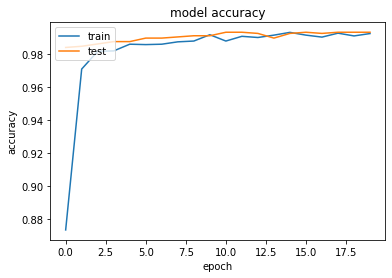

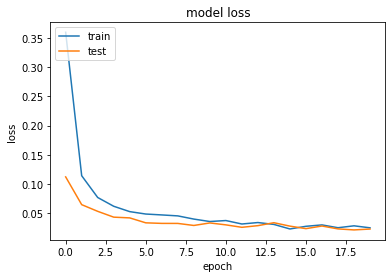

In [10]:
print(H.history.keys())
# summarize history for accuracy

plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Confusion Matrix


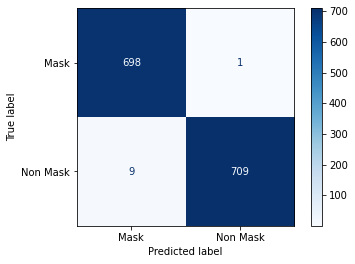

In [13]:
from sklearn.metrics import  confusion_matrix,ConfusionMatrixDisplay
print('Confusion Matrix')
cm = confusion_matrix(testY.argmax(axis=1),predIdxs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()